In [1]:
import gc
from os.path import join
from constants import LDA_PATH, LSI_PATH, PARAMS, NBTOPICS, VERSIONS, DATASETS
import pandas as pd
from gensim.models import LdaModel, LsiModel
from utils import load
import json
%pylab inline
import seaborn as sns
from itertools import islice, chain

pd.options.display.max_columns = 30
pd.options.display.width = 800
pd.options.display.precision = 3

Populating the interactive namespace from numpy and matplotlib


/home/andreas/bin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
pert = 'Perplexity (test)'
cohu = 'Coherence (u_mass)'
cohc = 'Coherence (c_v)'
conv = 'Convergence (jaccard)'
metrics = [pert, cohu, cohc, conv]


def load_metrics(dataset, nbfiles=None, version='noun', corpus='bow', epochs=30):
    param_ids = [f'{c}42_split' for c in list('abcde')]
    nb_topics_list = [10, 25, 50, 100]
    metrics = []
    for param_id in param_ids:
        for nb_topics in nb_topics_list:
            file = join(LDA_PATH, version, corpus, param_id, f'{dataset}_LDAmodel_{param_id}_{nb_topics}_ep{epochs}_metrics.json')
            try:
                with open(file, 'r') as fp:
                    data = json.load(fp)
            except FileNotFoundError as e:
                print(e)
            else:
                df = pd.DataFrame.from_dict(data)
                df = df.assign(
                    dataset=dataset,
                    param_id=param_id,
                    nb_topics=nb_topics,
                )
                df.index += 1
                df.index.name = 'epochs'
                df = df.set_index(['dataset', 'param_id', 'nb_topics'], append=True).reorder_levels([1, 2, 3, 0])
                df.columns = ['Perplexity (test)', 'Coherence (u_mass)', 'Coherence (c_v)',
                                       'Diff (kullback_leibler)', 'Convergence (jaccard)']
                metrics.append(df)
    return pd.concat(metrics)

def subframes(df, n):
    d = df.query(f'nb_topics == {n}')
    d.index = d.index.droplevel(['dataset', 'nb_topics'])
    d_pert = d[pert].unstack('epochs').T
    d_cohu = d[cohu].unstack('epochs').T
    d_cohc = d[cohc].unstack('epochs').T
    d_conv = d[conv].unstack('epochs').T
    return d_pert, d_cohu, d_cohc, d_conv

def prepare_data(dataset, nbfiles=None, version='noun', corpus='bow', epochs=30):
    df = load_metrics(dataset, nbfiles, version, corpus, epochs)
    subf = [subframes(df, 10), subframes(df, 25), subframes(df, 50), subframes(df, 100)]
    return df, subf

def plot_subframes(dataset, data, version='', corpus=''):
    sns.set()
    pylab.rcParams['figure.figsize'] = (20, 15)
    xticks=range(1, 31)

    fig, axs = plt.subplots(nrows=len(data), ncols=len(metrics))
    for i, subframes in enumerate(data):
        for j, kv in enumerate(zip(metrics, subframes)):
            metric, subframe = kv
            kwargs = dict()
            if i == 0:
                kwargs['title'] = metric
            if metric.startswith('Per'):
                kwargs['title'] = 'Perplexity'
                kwargs['logy'] = True
            subframe = subframe.rename(columns=lambda x: x.strip('_split'))
            if False: # set True to view the actual data -> verifies that tfidf b42 and c42 are almost (but not completely identical)
                print(dataset, version, corpus)
                print(subframe)
            subframe.plot(ax=axs[i][j], xticks=xticks, sharex=True, **kwargs)
    fig.suptitle(f'{dataset} -- {version} -- {corpus}', size=18, weight='heavy', x=.01, y=.99, ha='left', va='top')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
def run(version='noun', corpus='bow', epochs=30):
    datasets = ['dewac1', 'news', DATASETS['O'], 'speeches'] #+ ['dewac', 'dewiki']
            #+ [DATASETS['E'], DATASETS['FA'], DATASETS['FO'], DATASETS['P']]

    subfs = dict()
    for dataset in islice(datasets, None):
        df, subf = prepare_data(dataset, version=version, corpus=corpus, epochs=30)
        subfs[dataset] = subf
        plot_subframes(dataset, subf, version, corpus)
        
    # 1st key gives metrics for a dataset
    # 2nd key return the different topic sizes [0, 25, 50, 100] --> [-1]: training with 100 topics
    # 3rd key returns the evaluation metric [perplexity, coherence u_mass, coherence c_v, convergence] --> [2]: C_v evaluation metric
    # 4th key returns the last training epoch where our topics come from
    sets = []
    results = []
    for dataset in datasets:
        res = subfs[dataset][-1][2].iloc[-1, :]
        sets.append(dataset)
        results.append(res)
        print(dataset, ':', res.idxmax(), res.max())

    df = pd.concat(results, axis=1)
    df.columns = sets
    print(df.sum(axis=1).sort_values(ascending=False))
    #print(df.T.describe())
    pylab.rcParams['figure.figsize'] = (10, 7)
    fig, axs = plt.subplots(nrows=1, ncols=1)
    df.T.boxplot(ax=axs)

dewac1 : b42_split 0.495881646470224
news : a42_split 0.5300942213401538
OnlineParticipation : e42_split 0.4352247759191169
speeches : d42_split 0.40311021073974307
param_id
a42_split    1.833
c42_split    1.830
b42_split    1.830
d42_split    1.779
e42_split    1.644
dtype: float64


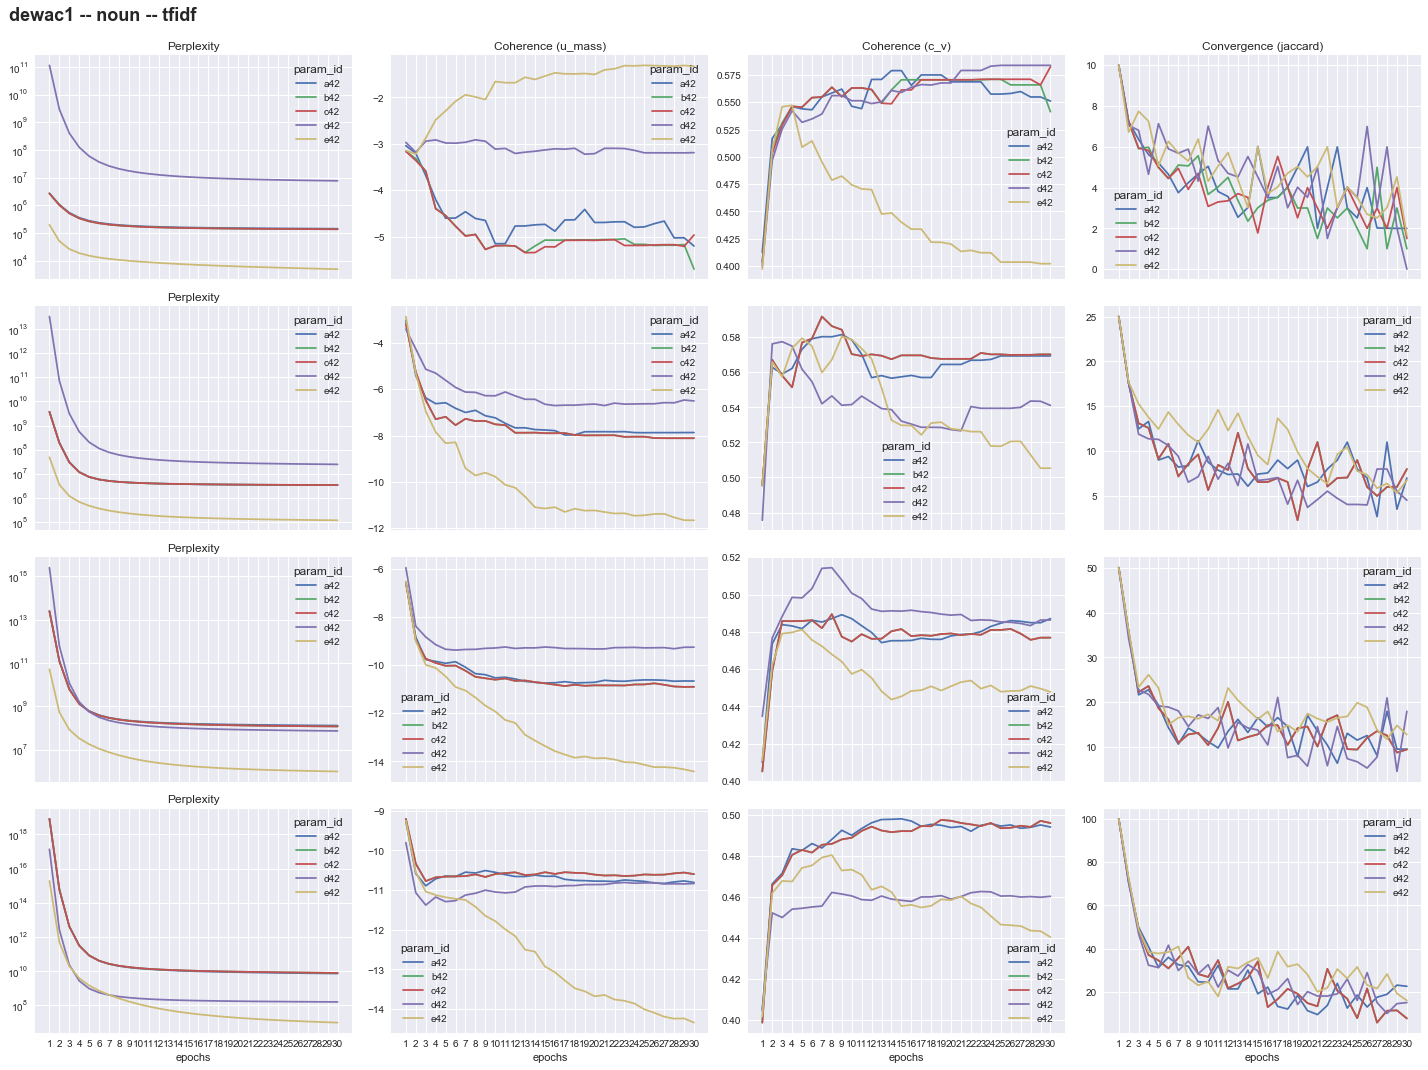

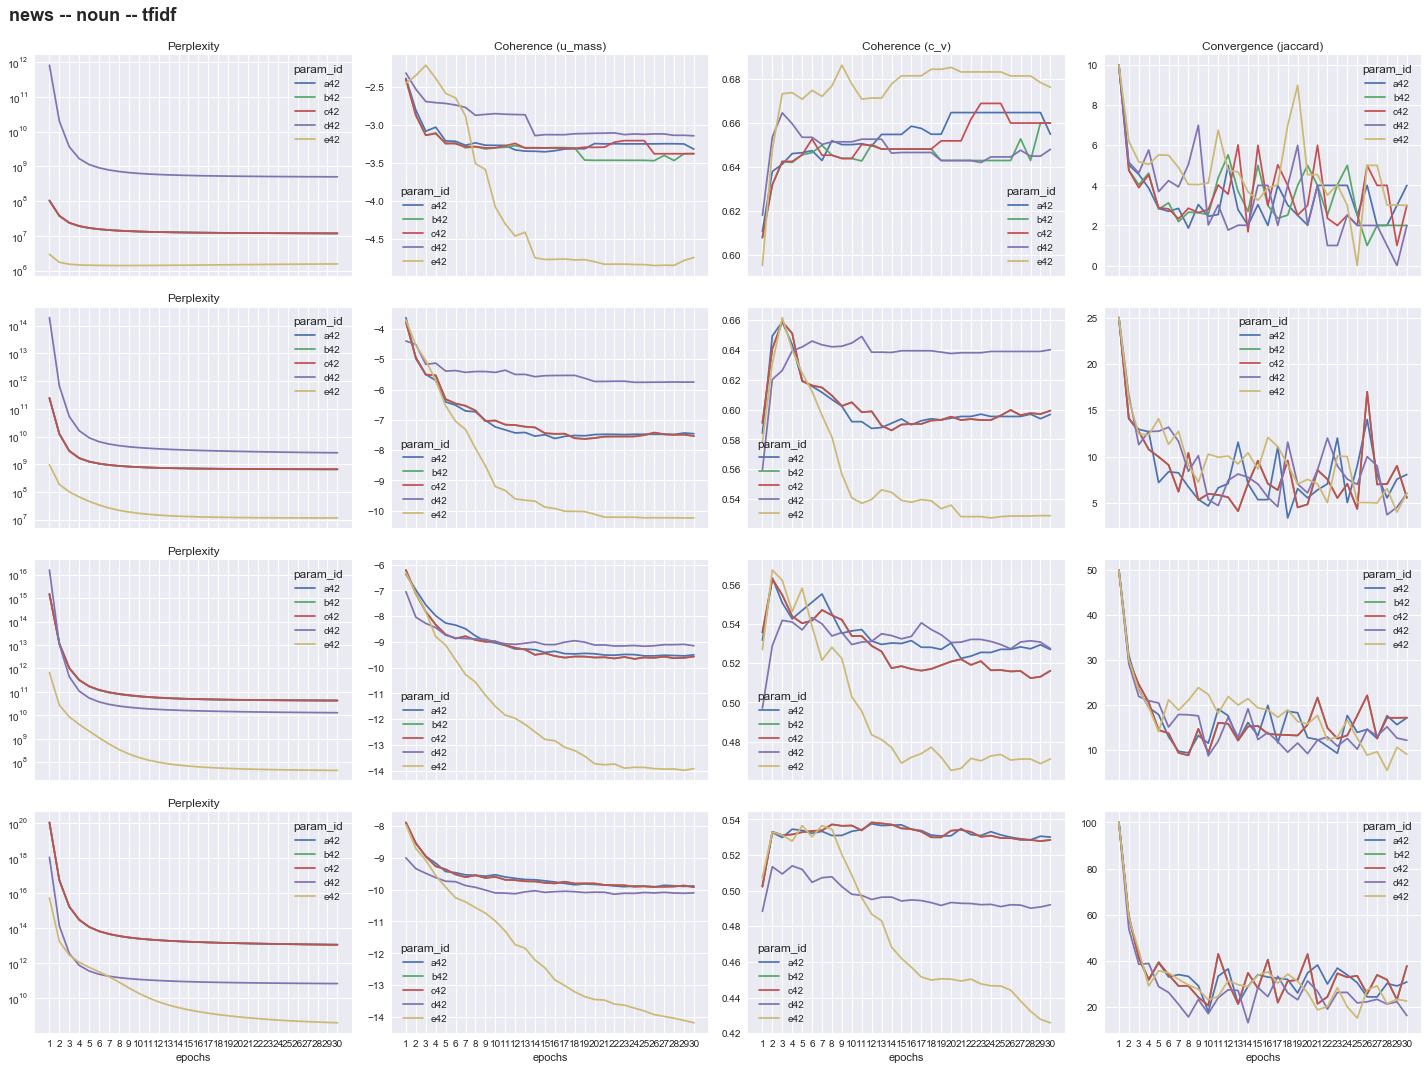

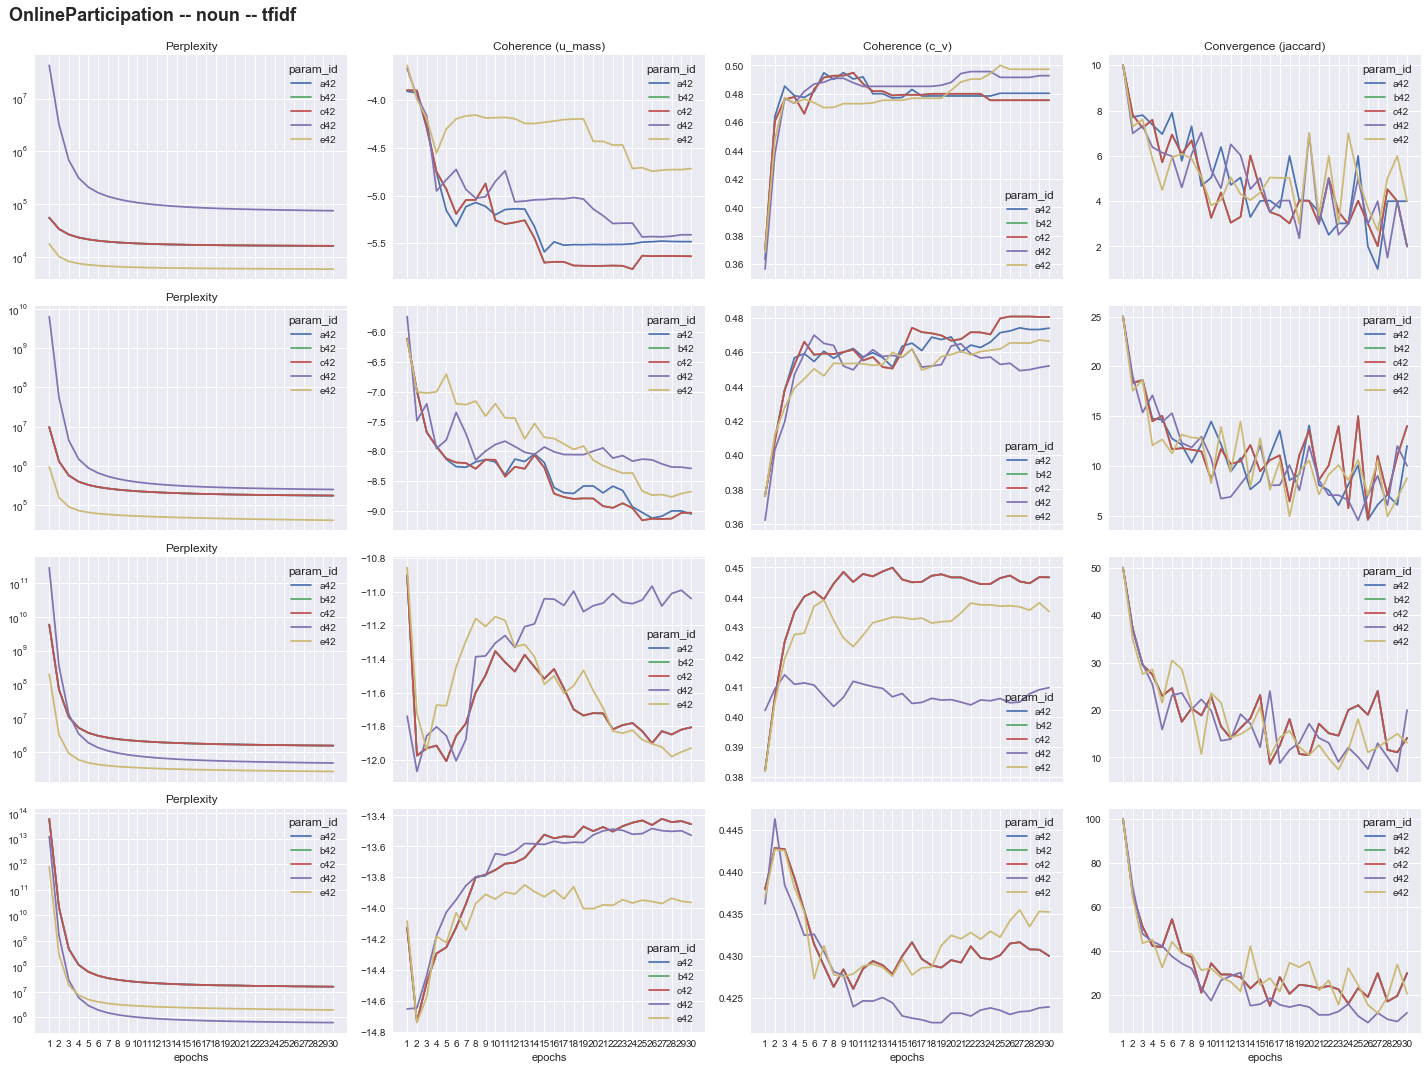

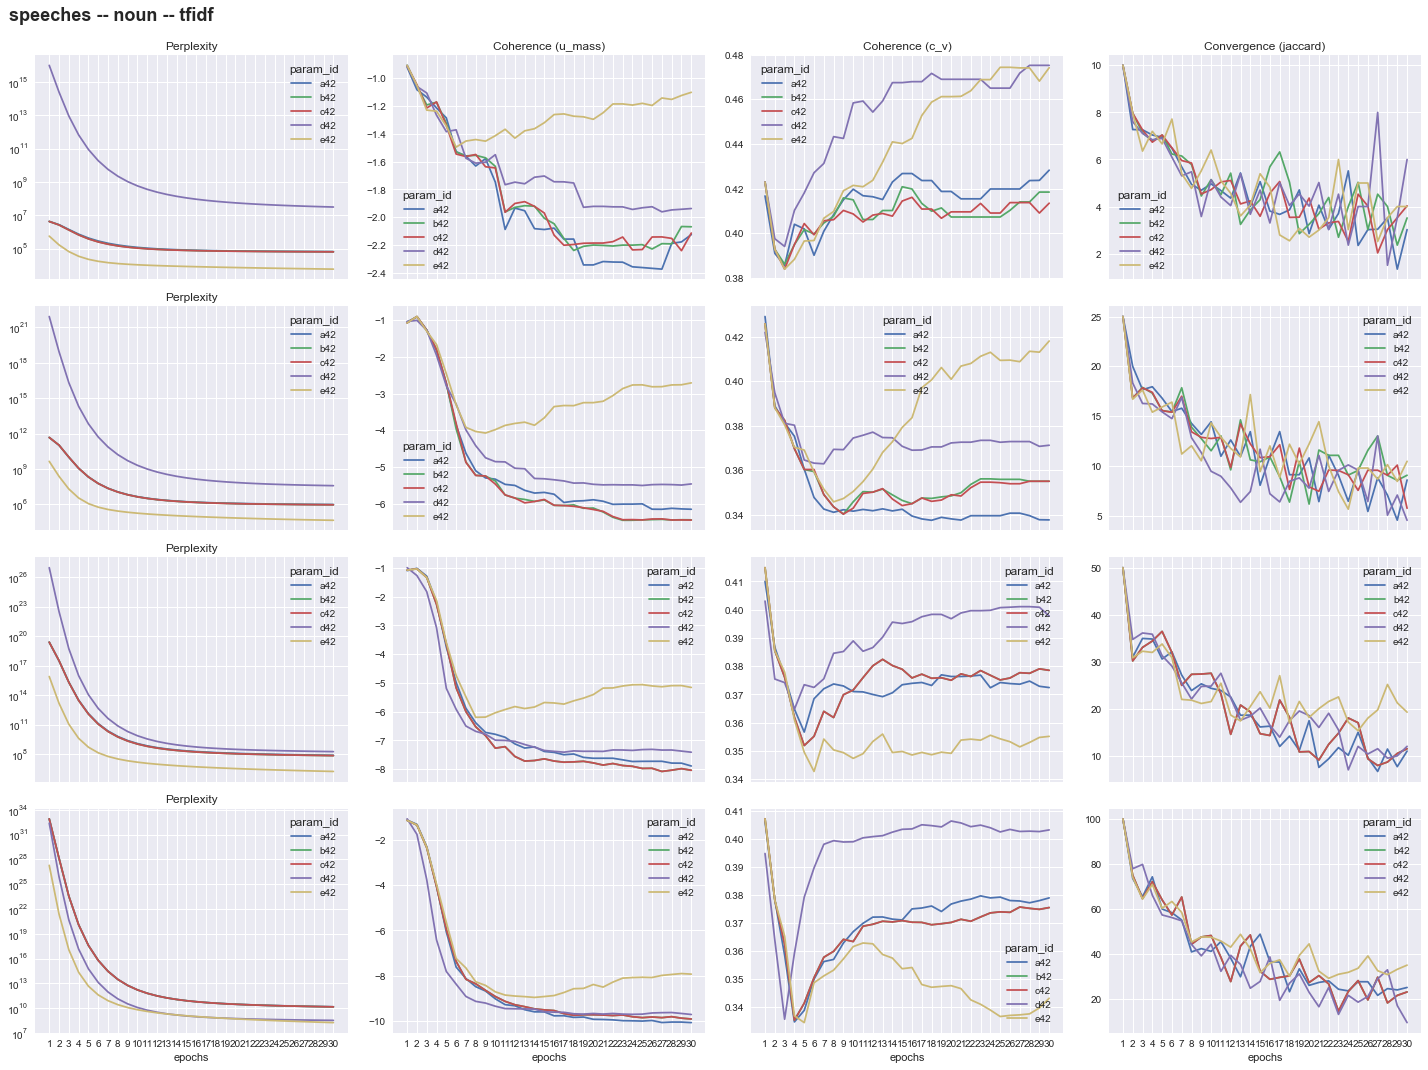

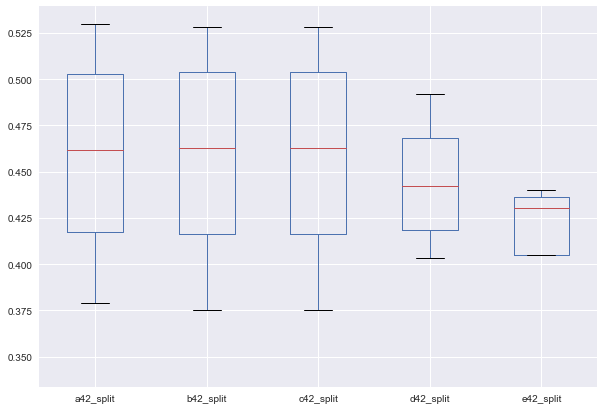

In [5]:
run(version='noun', corpus='tfidf', epochs=30)

dewac1 : a42_split 0.6442947370298188
news : e42_split 0.6387365024267172
OnlineParticipation : e42_split 0.4504211866447064
speeches : a42_split 0.5100187976122513
param_id
a42_split    2.202
c42_split    2.200
b42_split    2.200
e42_split    2.192
d42_split    2.114
dtype: float64


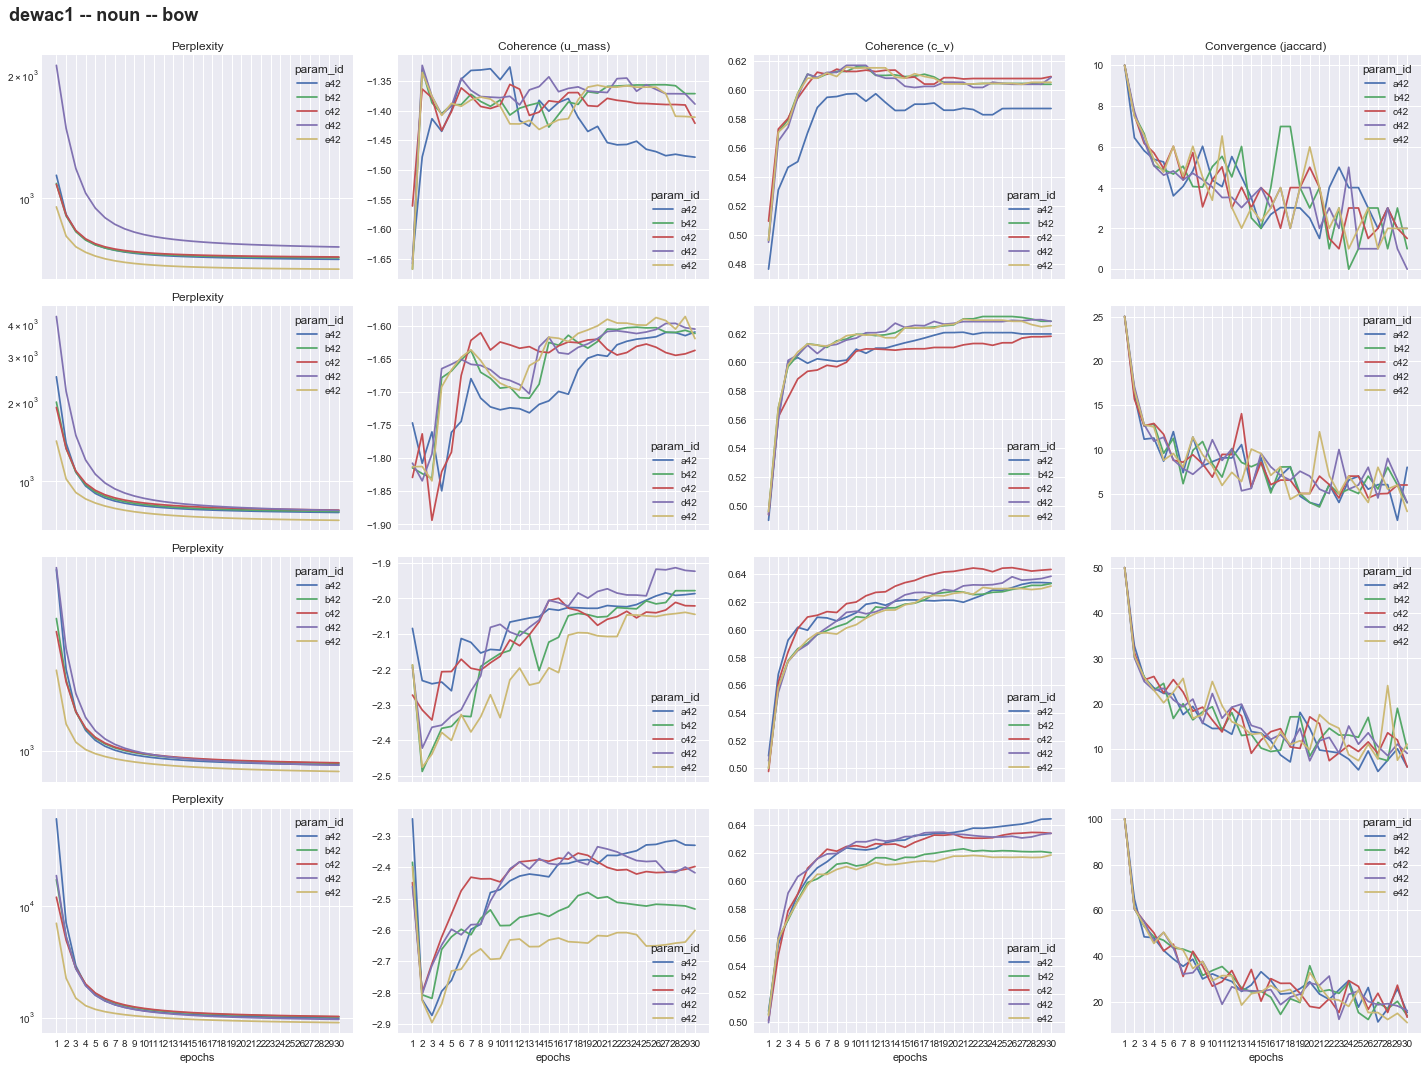

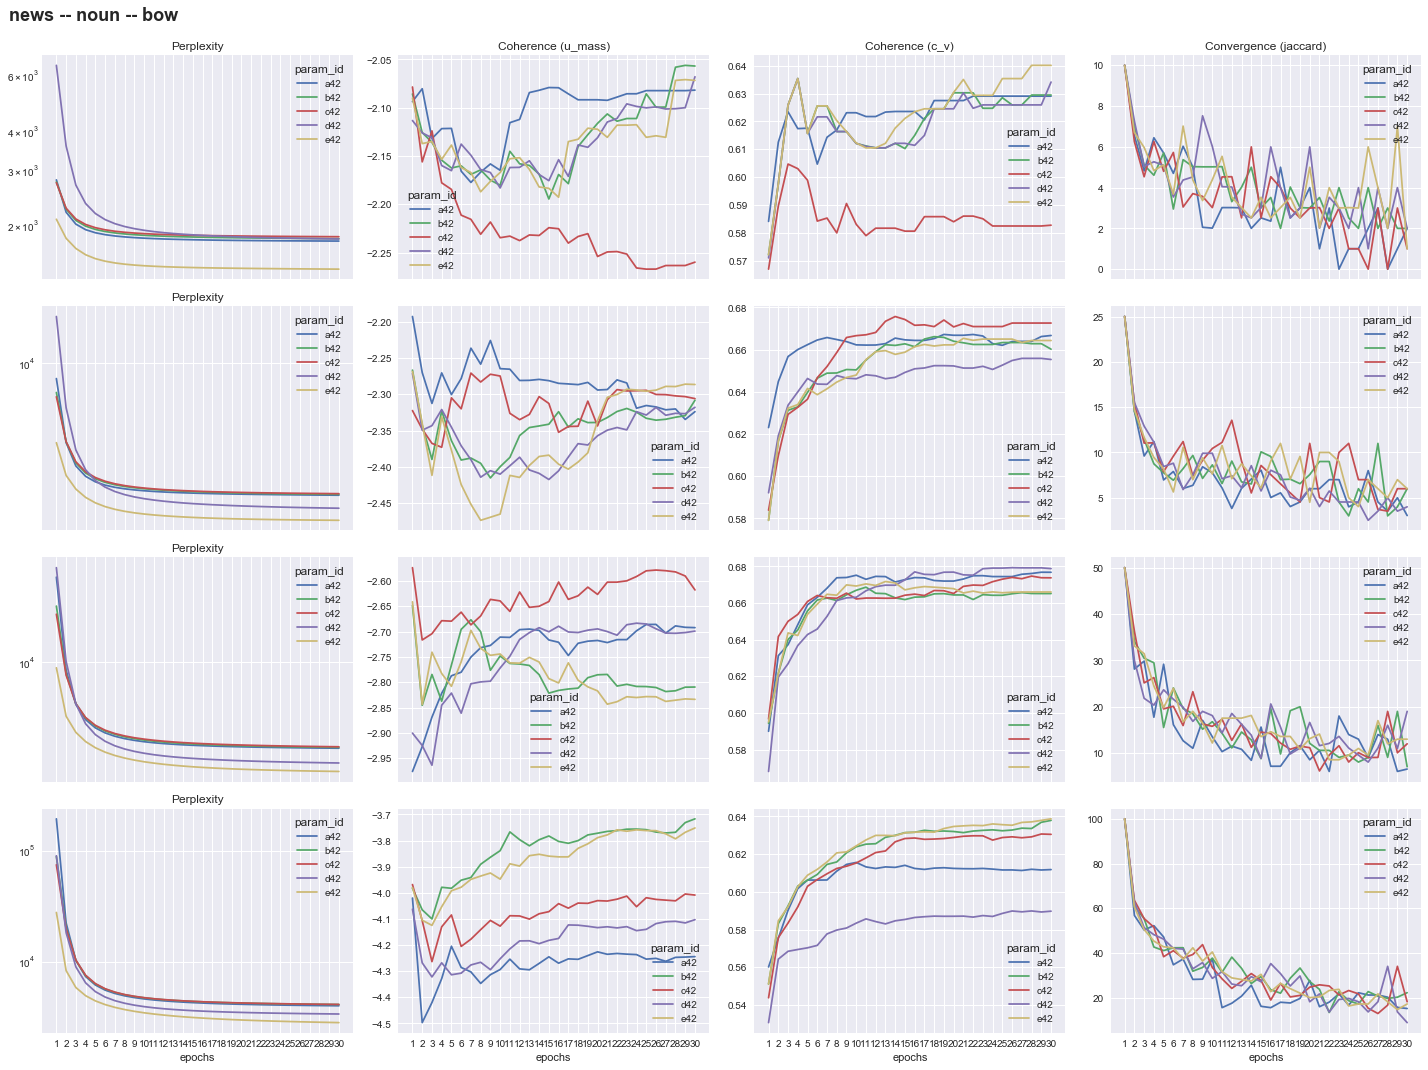

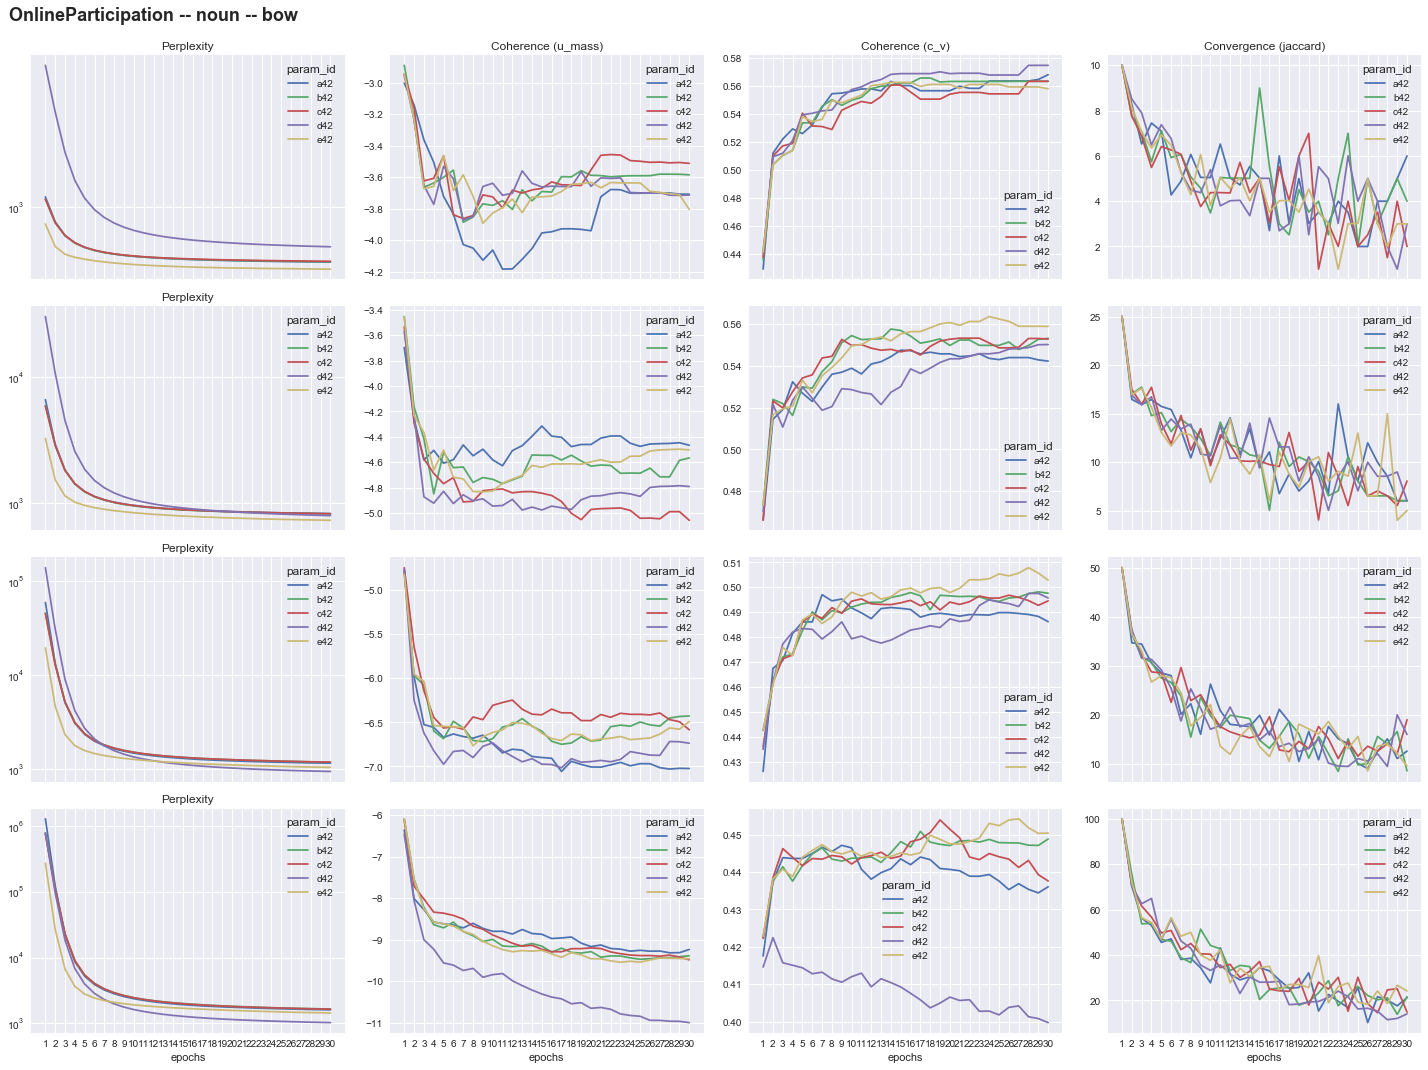

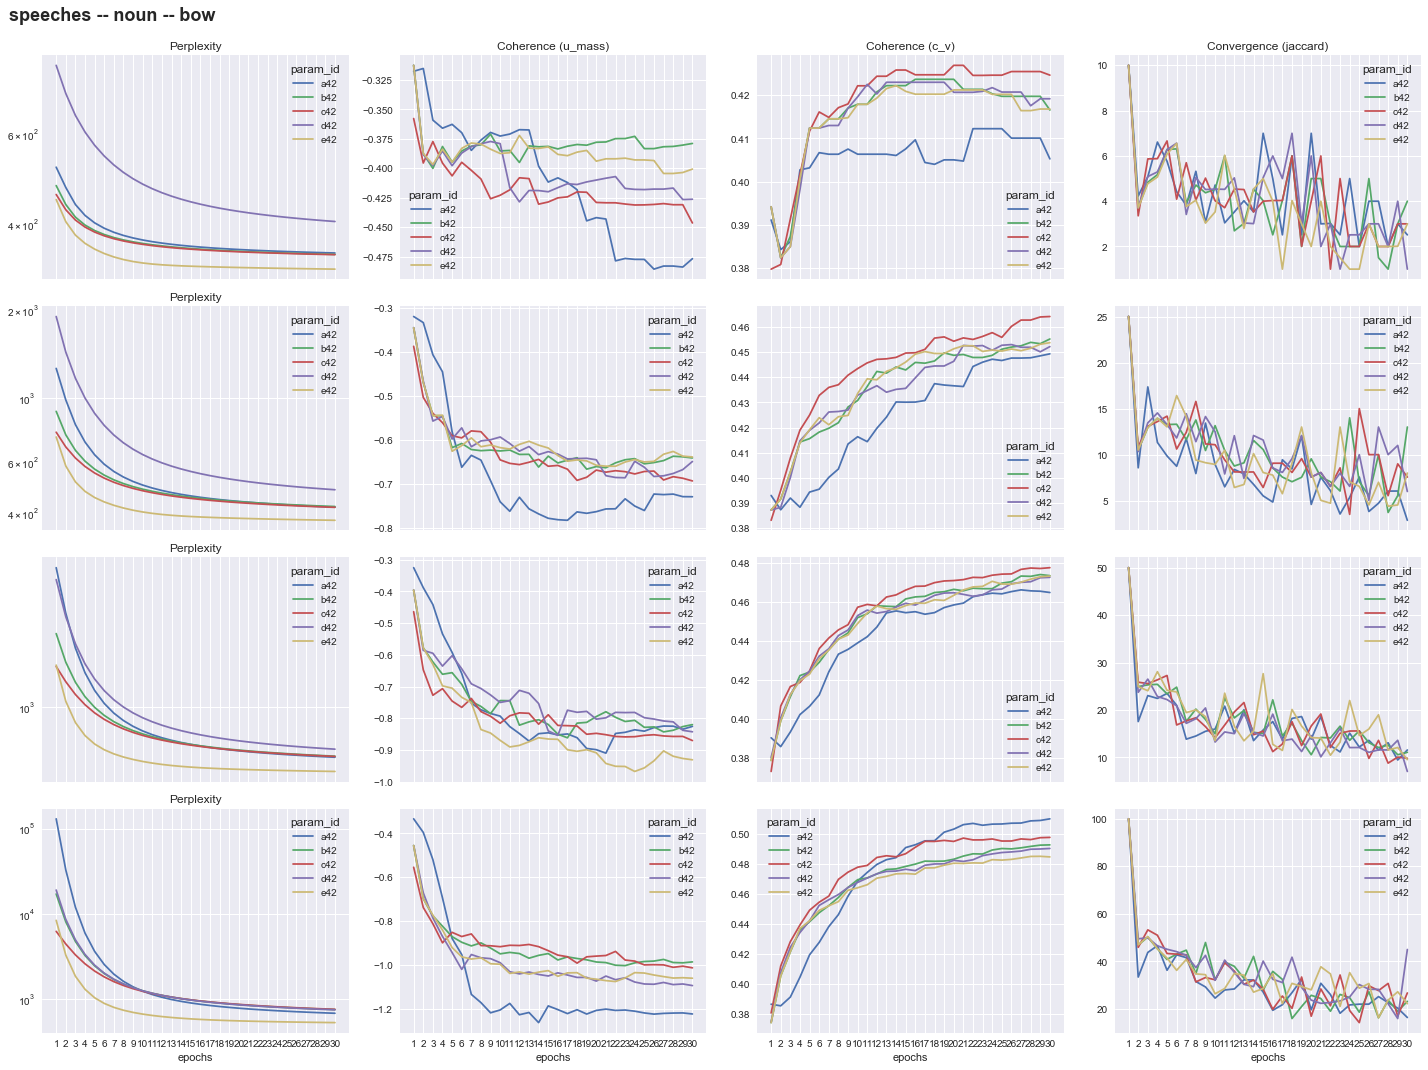

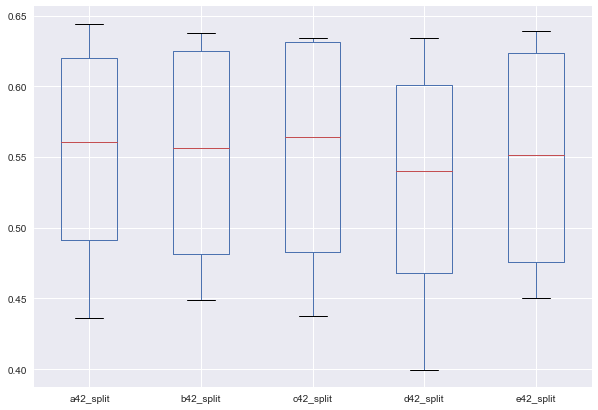

In [15]:
run(version='noun', corpus='bow', epochs=30)

dewac1 : d42_split 0.6257771413345221
news : a42_split 0.594911487399094
OnlineParticipation : a42_split 0.47938926777853136
speeches : c42_split 0.5256382768353306
param_id
a42_split    2.199
c42_split    2.186
b42_split    2.175
d42_split    2.175
e42_split    2.144
dtype: float64


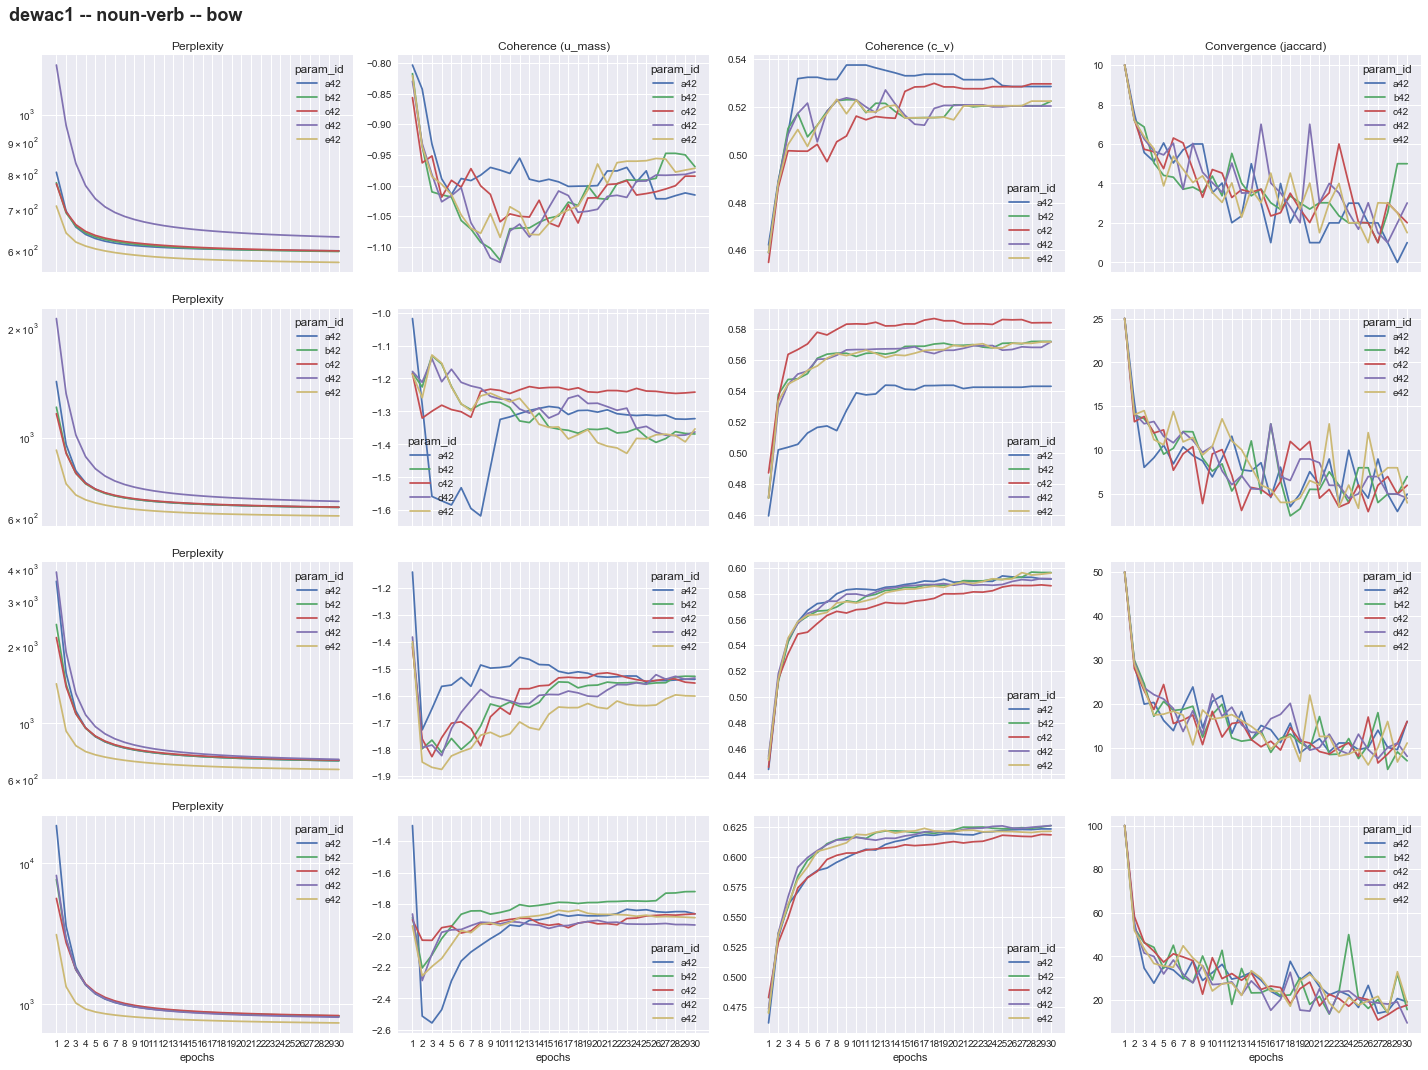

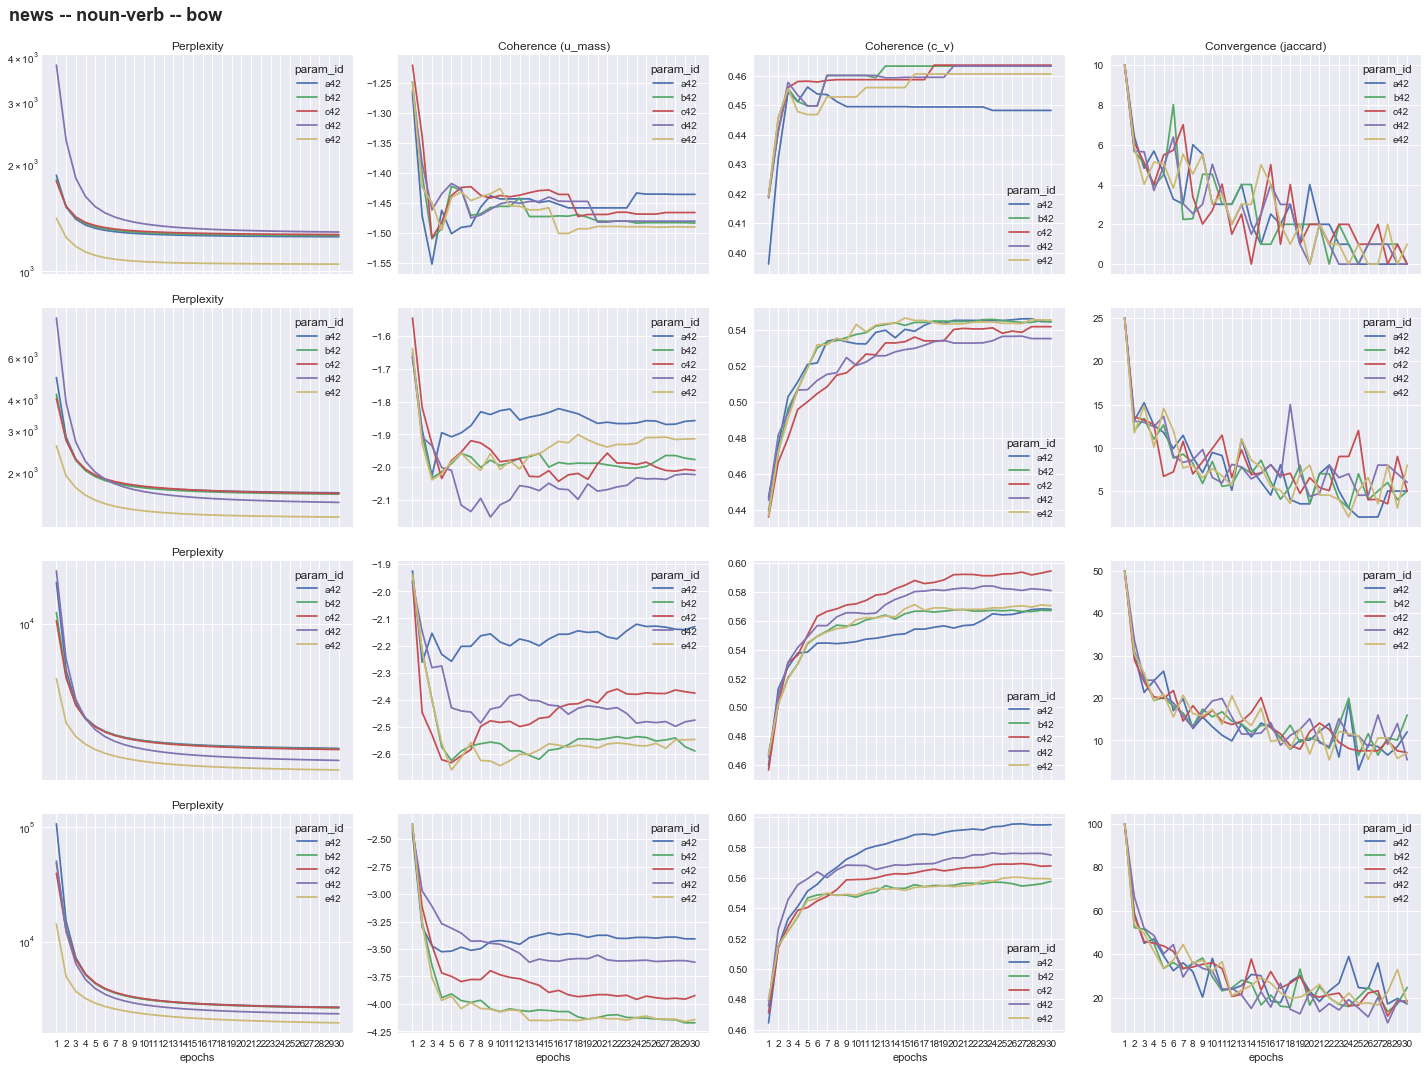

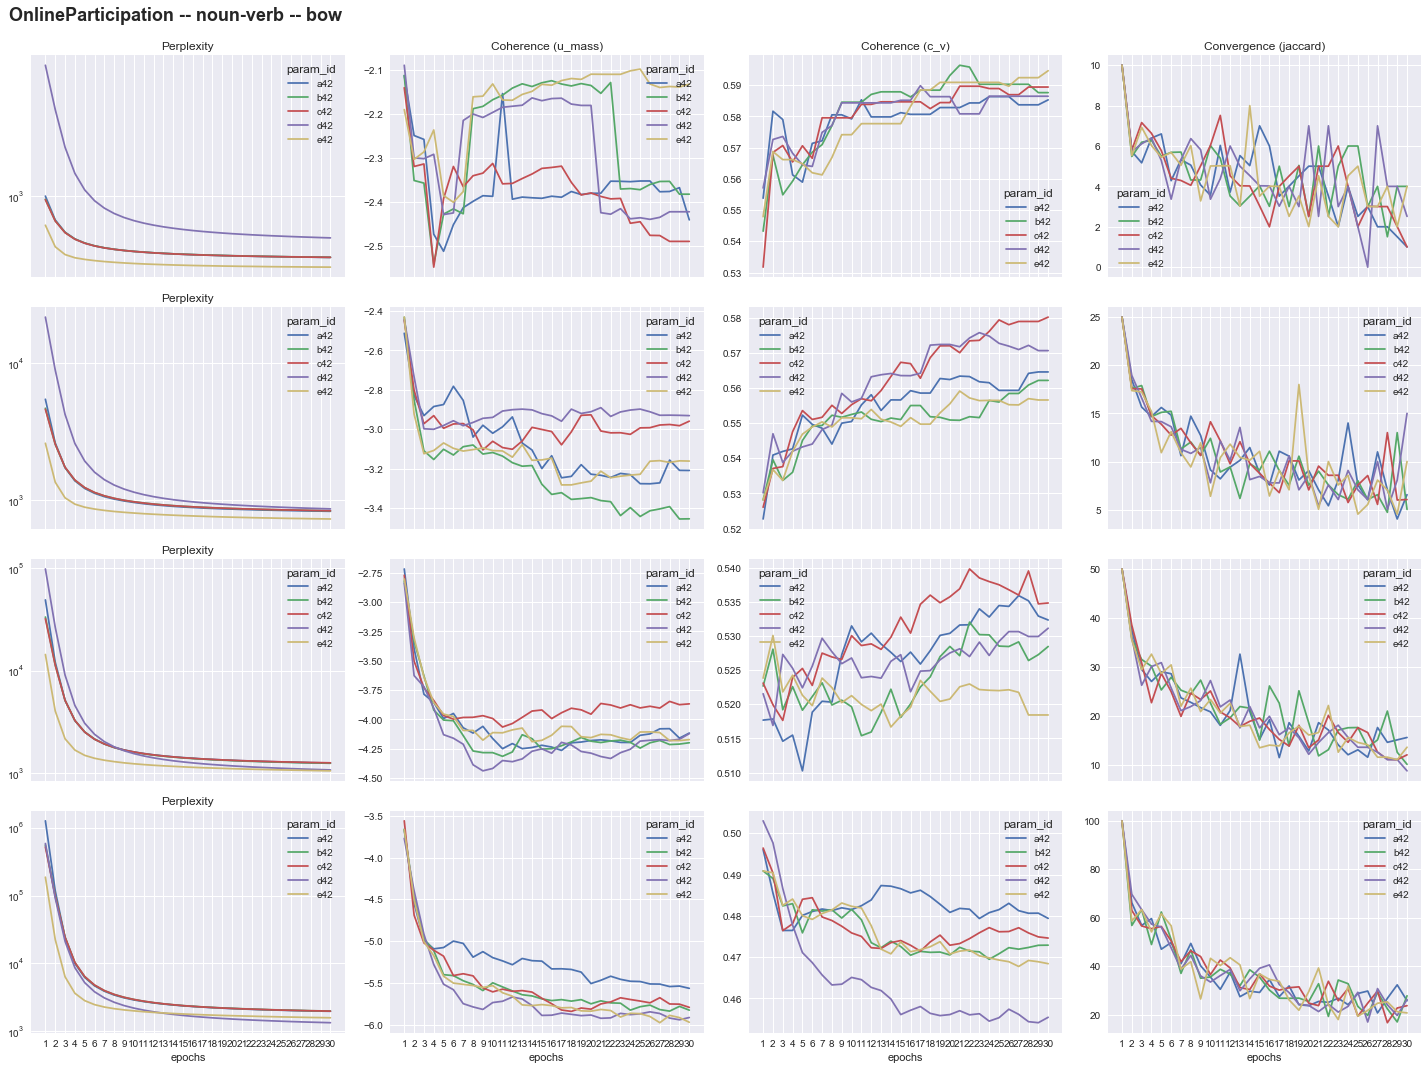

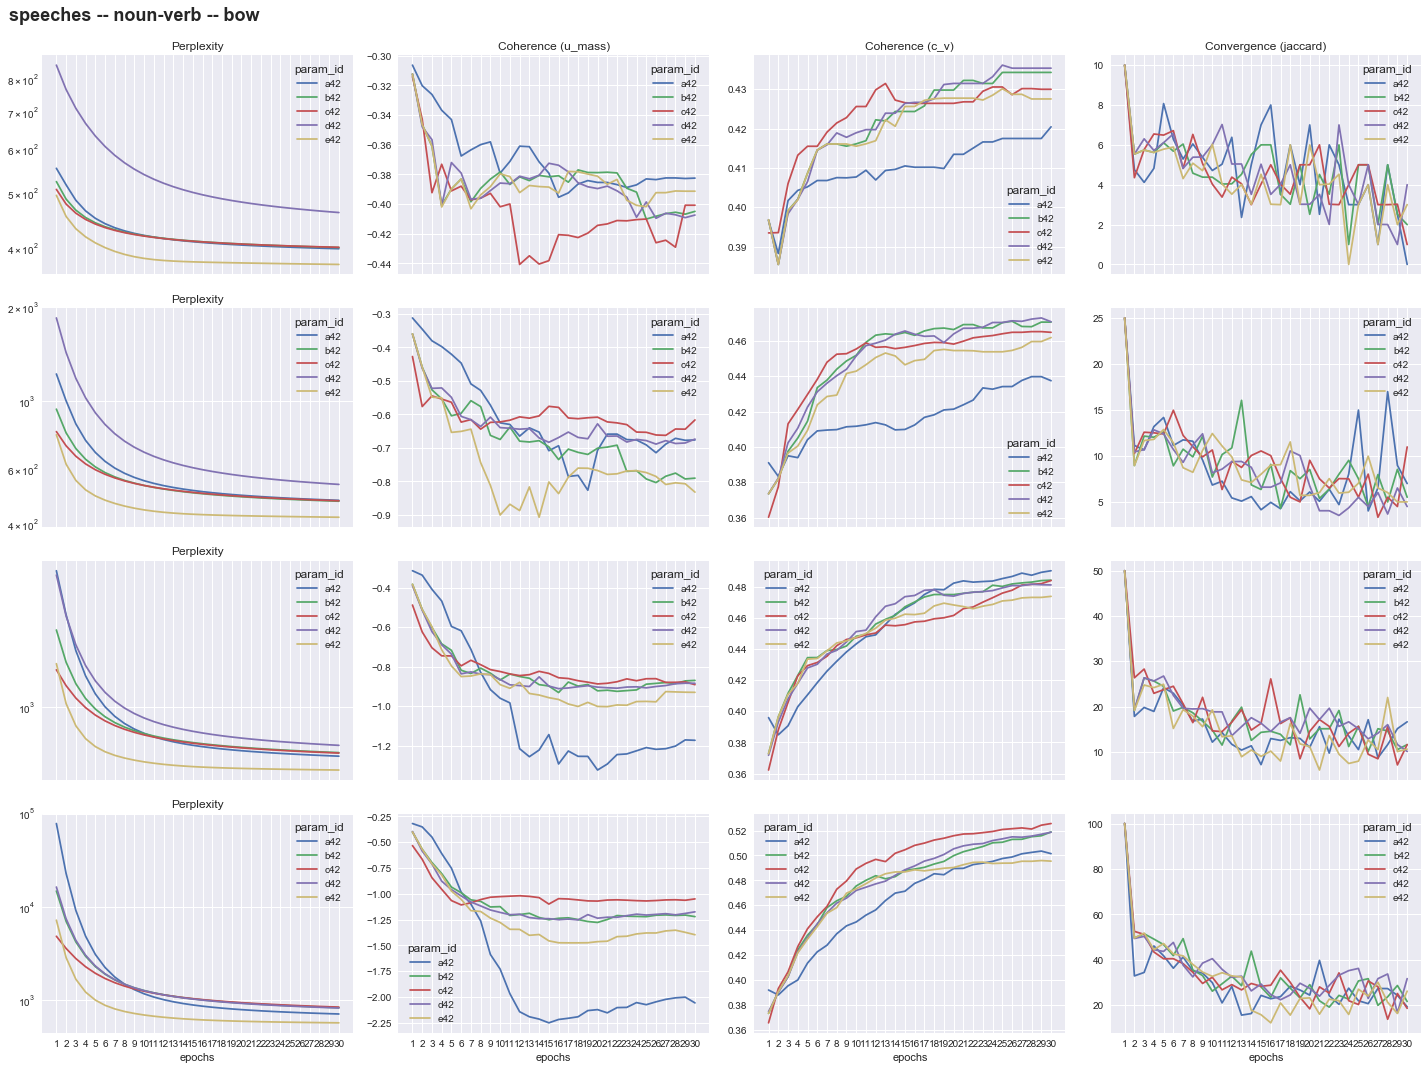

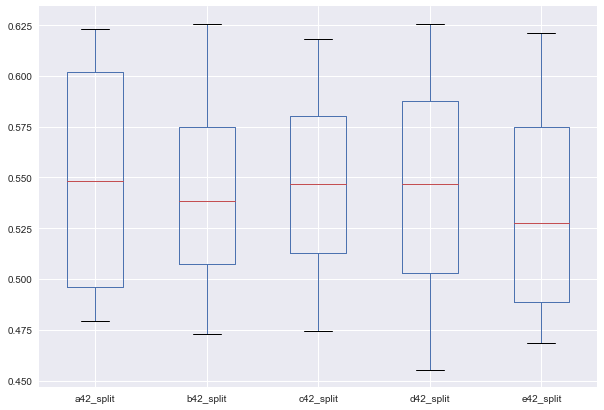

In [16]:
run(version='noun-verb', corpus='bow', epochs=30)

dewac1 : d42_split 0.6257771413345221
news : d42_split 0.5796804975489056
OnlineParticipation : c42_split 0.4760118008429487
speeches : c42_split 0.5259688220429358
param_id
b42_split    2.194
d42_split    2.193
c42_split    2.193
e42_split    2.185
a42_split    2.164
dtype: float64


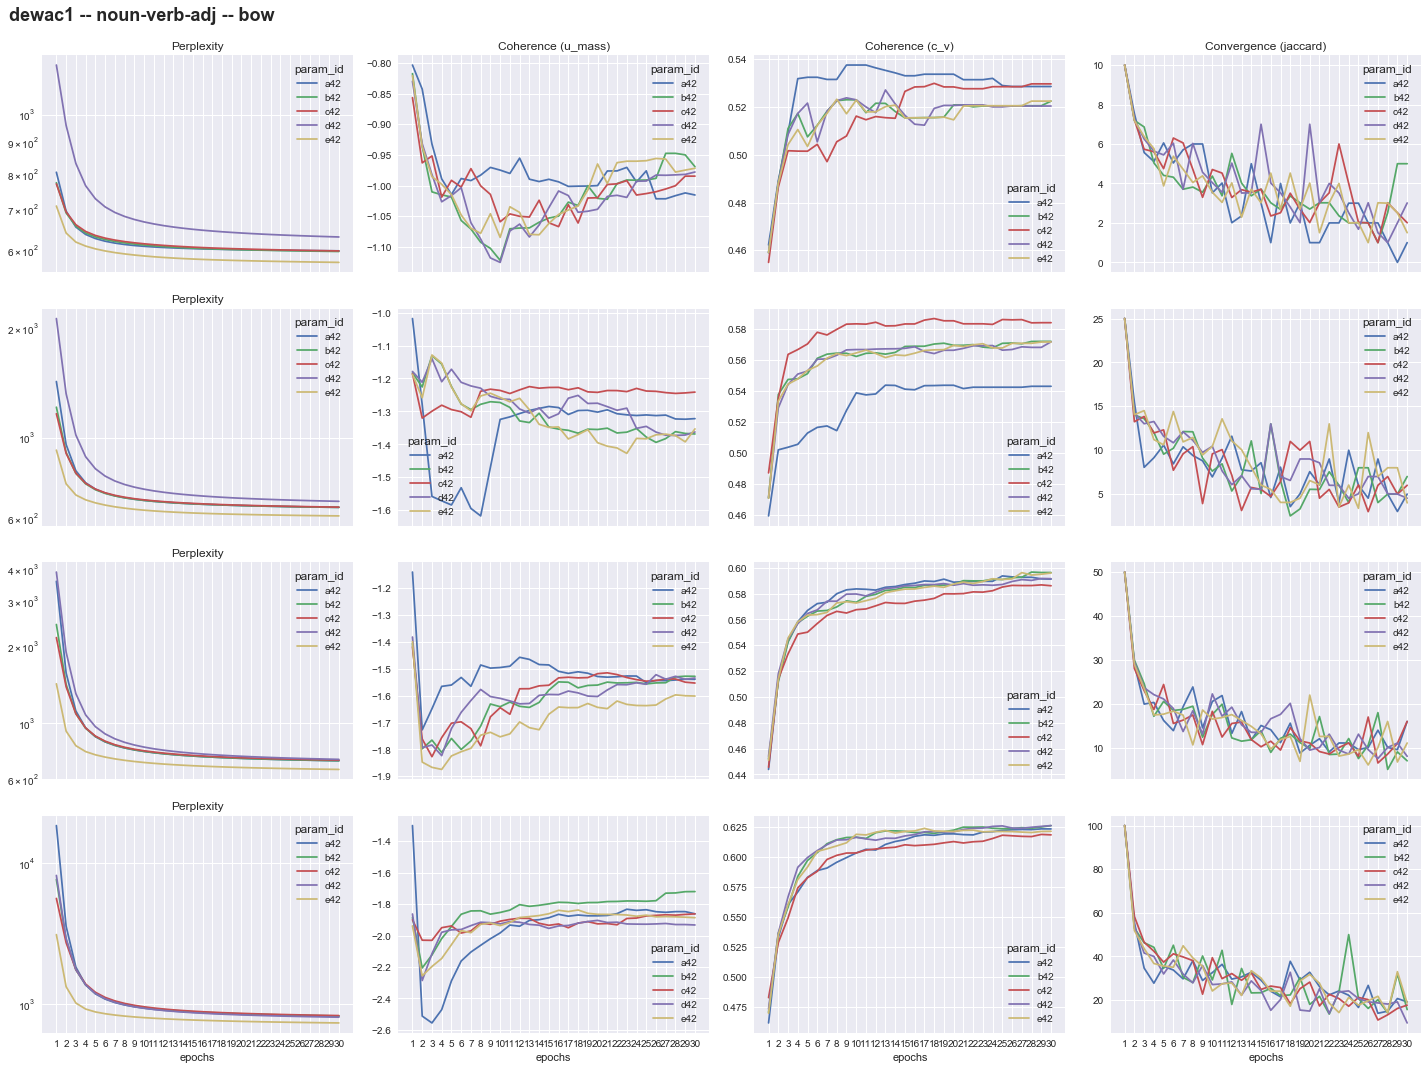

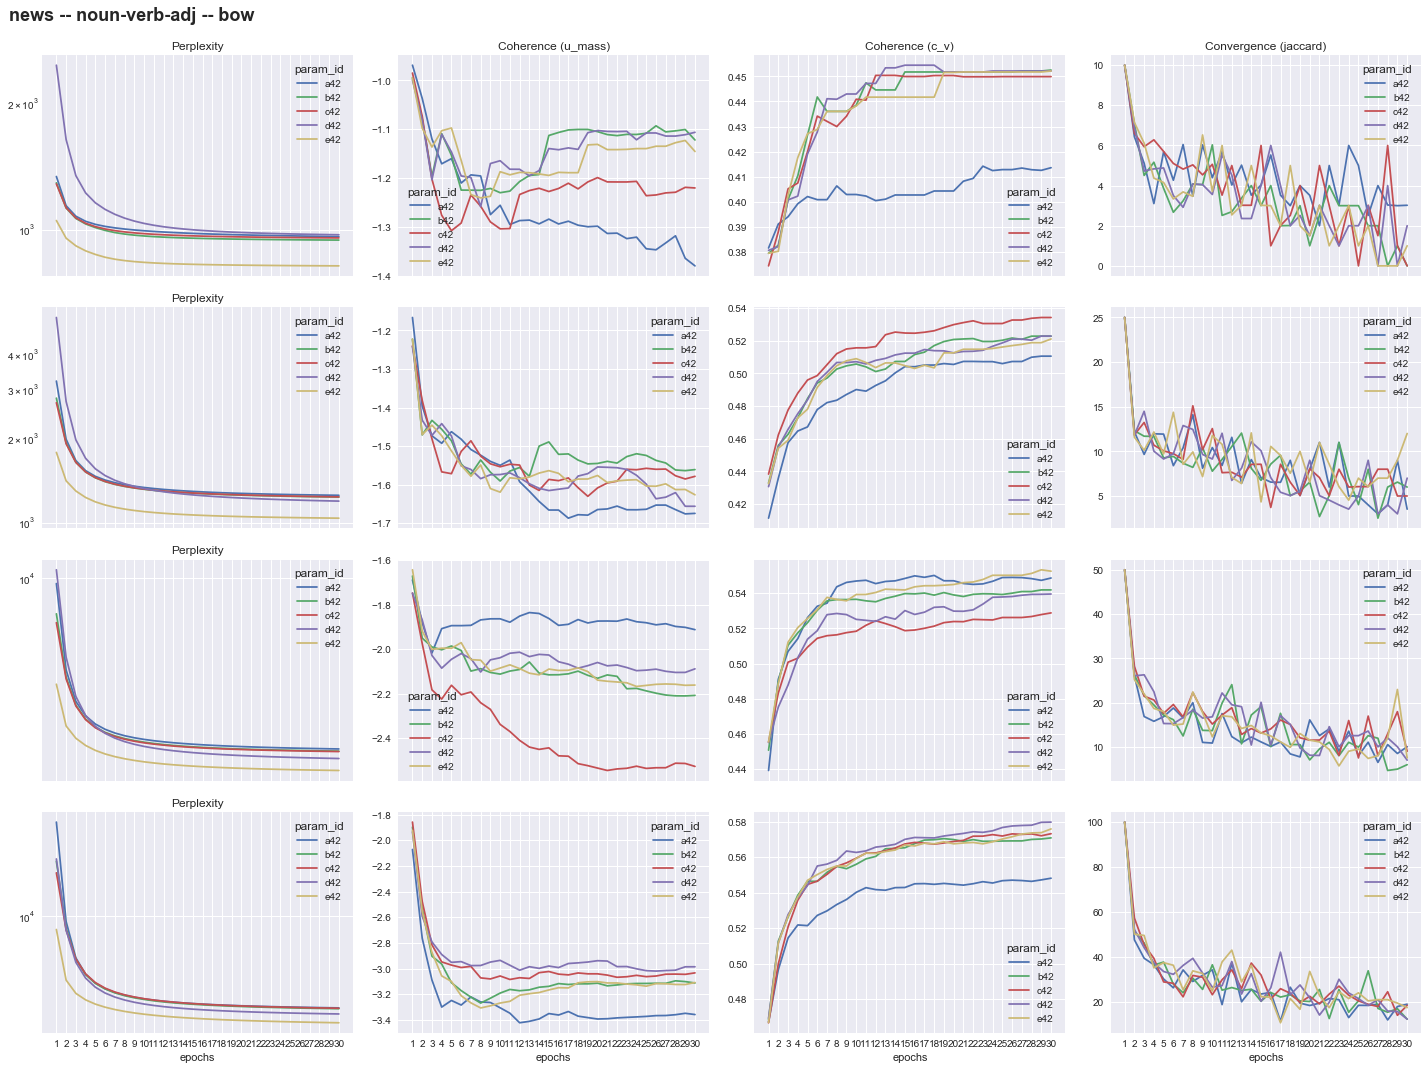

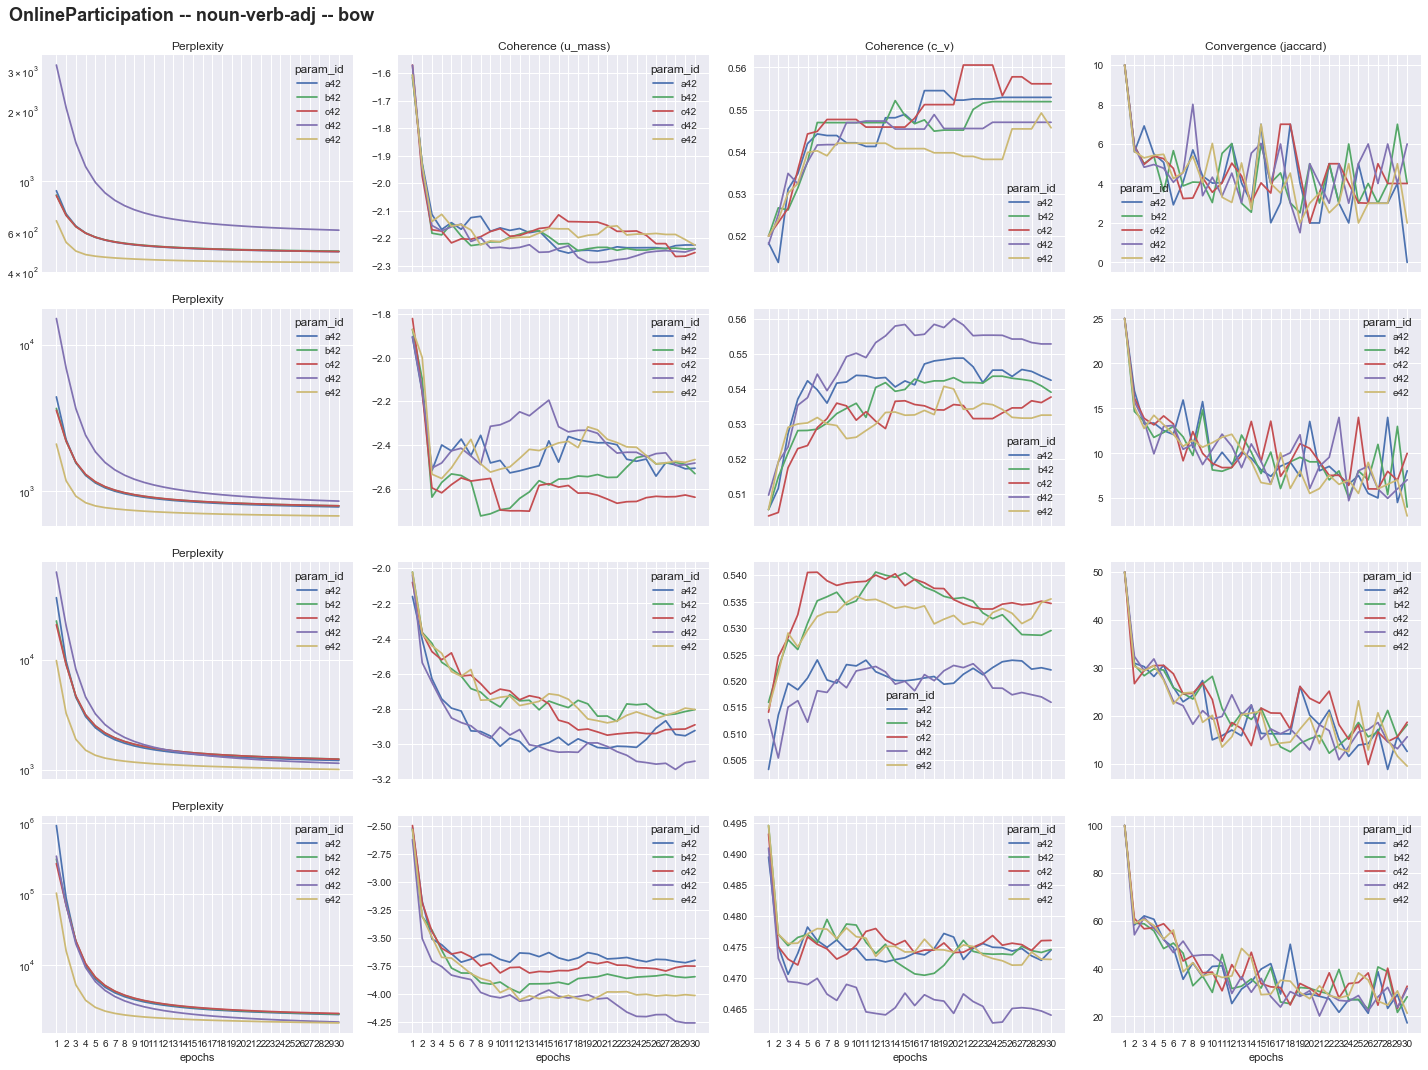

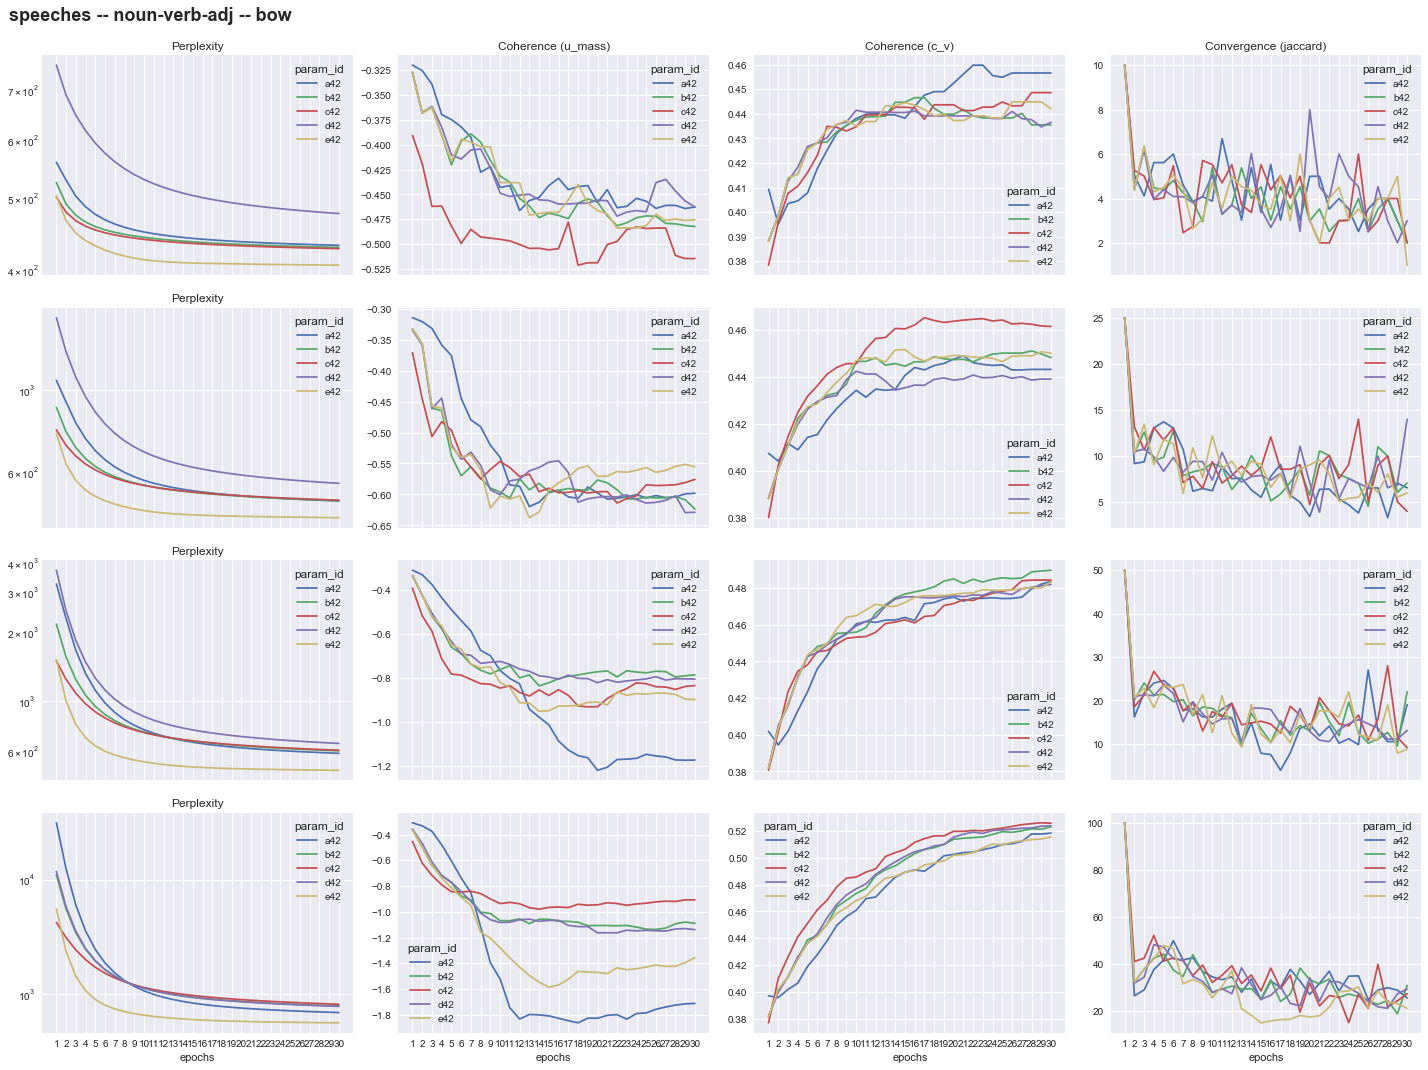

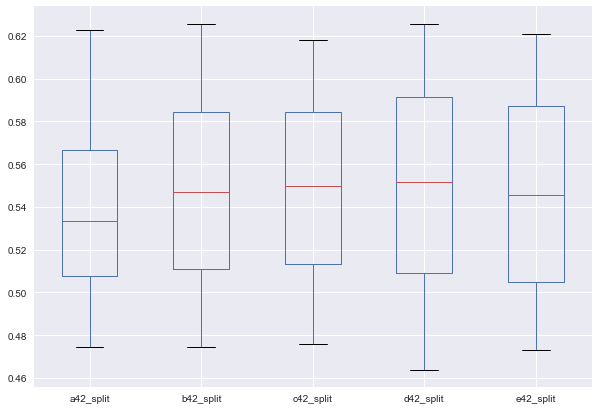

In [7]:
run(version='noun-verb-adj', corpus='bow', epochs=30)